In [1]:
import rosbag
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
%matplotlib inline

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def to_euler(x, y, z, w):
    """Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])

In [3]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

In [19]:
bag = rosbag.Bag('rosbag/27Okt_Cooperative.bag')
bag.get_type_and_topic_info()
content = []
# print(bag)
# input_steer = []
for topic, msg, _ in bag.read_messages(topics=['/game_theory_AV']):
    content.append(msg)
print(content[0])

header: 
  seq: 1
  stamp: 
    secs: 1635324705
    nsecs: 663433074
  frame_id: "agv_trajectory_control_game_theory"
action_steer: 0.0
action_throttle: 0.0
action_brake: 0.0
error_lateral: 225.8000030517578
error_yaw: 116.5999984741211
error_speed: 3.140000104904175
actual_x: 225.8
actual_y: 119.9
actual_yaw: 218.8000030517578
actual_speed: 119.9
target_x: 218.8
target_y: 119.9
target_brake: 3.14
pmap: []
potential_x: [218.8000030517578]
potential_y: [119.9000015258789]
deg_ref_yaw: 0.0
deg_actual_yaw: 0.0
deg_error_yaw: 0.0


In [12]:
# untuk plot estimator
# x_estimator = []
# y_estimator = []
# yaw_estimator = []
# waktu_estimator = []

# plot trajectory
x_now = []
y_now = []
x_target_sigmoid = []
y_target_sigmoid = []
x_sub_sigmoid = []
y_sub_sigmoid = []
x_sigmoid = []
y_sigmoid = []

for topic, msg, _ in bag.read_messages(topics=['/control_signal_game']):
    x_now.append(msg.actual_x)
    y_now.append(msg.actual_y)
    x_target_sigmoid.append(msg.target_x)
    y_target_sigmoid.append(msg.target_y)
    x_sub_sigmoid.append(msg.actual_yaw)
    y_sub_sigmoid.append(msg.actual_speed)
    x_sigmoid.append(msg.potential_x)
    y_sigmoid.append(msg.potential_y)
#     yaw_estimator.append(msg.yaw_gnss_fr)
#     waktu_estimator.append(msg.header.stamp.to_sec())
# yaw_estimator = wrap_angle(np.array(yaw_estimator))

In [20]:
# untuk plot estimator
# x_estimator = []
# y_estimator = []
# yaw_estimator = []
# waktu_estimator = []

# plot trajectory
x_now = []
y_now = []
x_target_sigmoid = []
y_target_sigmoid = []
x_other = []
y_other = []
x_sigmoid = []
y_sigmoid = []
yaw_now = []

for topic, msg, _ in bag.read_messages(topics=['/game_theory_AV']):
    x_now.append(msg.actual_x)
    y_now.append(msg.actual_y)
    yaw_now.append(msg.target_brake)
#     x_target_sigmoid.append(msg.target_x)
#     y_target_sigmoid.append(msg.target_y)
    x_other.append(msg.error_lateral)
    y_other.append(msg.error_yaw)
    x_sigmoid.append(msg.potential_x)
    y_sigmoid.append(msg.potential_y)
#     yaw_estimator.append(msg.yaw_gnss_fr)
#     waktu_estimator.append(msg.header.stamp.to_sec())
# yaw_estimator = wrap_angle(np.array(yaw_estimator))

In [21]:
print(len(x_now),len(x_sigmoid),len(yaw_now))

185 185 185


In [7]:
# modif untuk trajectory
# dst = 0.5 
# # dst = 0.05
# X = np.copy(x_estimator)
# Y = np.copy(y_estimator)
# T = np.copy(waktu_estimator)
# YAW = np.copy(yaw_estimator)

# filter_x = [X[0]]
# filter_y = [Y[0]]
# filter_yaw = [YAW[0]]
# filter_t = [T[0]]

# for i in range(1, X.shape[0]):
#     dist = np.sqrt((X[i] - filter_x[-1])**2 + (Y[i] - filter_y[-1])**2)
# #     while dist >= dst:
#     if dist >= dst:
#         filter_x.append(X[i])
#         filter_y.append(Y[i])
#         filter_yaw.append(YAW[i])
#         filter_t.append(T[i])
#         dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)

In [8]:
# print(len(x_estimator), len(filter_x))

In [22]:
def create_vehicle_safe_zone(x, y, yaw):
    X_others = x
    Y_others = y
    yaw_others = yaw
#     print(type(X_others),type(Y_others),type(yaw_others))
    l_car = 5
    w_car = 2
    l_car_safe = 1.1 * l_car
    w_car_safe = 1.25 * w_car
#     l_car_safe = l_car
#     w_car_safe = w_car

    safe_zone = [[X_others-l_car_safe/2*np.cos(yaw_others)+w_car_safe/2*np.sin(yaw_others),
            Y_others-l_car_safe/2*np.sin(yaw_others)-w_car_safe/2*np.cos(yaw_others)],
            [X_others-l_car_safe/2*np.cos(yaw_others)-w_car_safe/2*np.sin(yaw_others),
            Y_others-l_car_safe/2*np.sin(yaw_others)+w_car_safe/2*np.cos(yaw_others)],
            [X_others+l_car_safe/2*np.cos(yaw_others)-w_car_safe/2*np.sin(yaw_others),
            Y_others+l_car_safe/2*np.sin(yaw_others)+w_car_safe/2*np.cos(yaw_others)],
            [X_others+l_car_safe/2*np.cos(yaw_others)+w_car_safe/2*np.sin(yaw_others),
            Y_others+l_car_safe/2*np.sin(yaw_others)-w_car_safe/2*np.cos(yaw_others)]]
    return safe_zone

In [23]:
# df = pd.read_csv("test2.csv")
# len(df2['Time step'])
# print(len(df['Time step'])-14, len(df2['Time step']))
# df['long'][0]
!rm -r movement_plot_animation_steps

In [24]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
# import math

# plot_lim = [[np.min(df['long'])-0.00010, np.max(df['long']+0.00010)],
#             [np.min(df['lat'])-0.00010, np.max(df['lat'])+0.00010]]

plot_lim = [[120 , 235],
            [100, 140]]

filename = 'movement_plot_animation'
buf_folder = filename+'_steps'
!mkdir $buf_folder
figsize=(15,15)
dpi=100
framecounter=0
# redmi_long = []
# redmi_lat = []
# samsung_long = []
# samsung_lat = []
x_plot = []
y_plot = []
y_ot = []
x_ot = []

x_br = 190.8
y_br = 119.9

print("Frame rendering started...")
for i in range(len(x_now)):
    # i = len(log["x_head"])-2
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax1 = fig.add_subplot(111)
    
    # Path visual
    x_plot = x_now[i]
    y_plot = y_now[i]
    x_ot = x_other[i]
    y_ot = y_other[i]
    x_sigm = x_sigmoid[i]
    y_sigm = y_sigmoid[i]
    
    # safe zone
    sz = create_vehicle_safe_zone(x_plot, y_plot, yaw_now[i])
    xs,ys = Polygon(sz).exterior.xy
    
    # safe zone other
    szot = create_vehicle_safe_zone(x_ot, y_ot, 3.14)
    xsot, ysot = Polygon(szot).exterior.xy
    
    # static obstacle
    AV_br = create_vehicle_safe_zone(x_br, y_br, 3.14)
    xbr,ybr= Polygon(AV_br).exterior.xy
        
    # path plot
    ax1.scatter(x=x_plot, y=y_plot, c='blue',marker='x', label="vehicle position")
    ax1.scatter(x=x_ot, y=y_ot, c='green',marker='x', label="other_vehicle")
    ax1.scatter(x=x_br, y=y_br, c='red',marker='o', label="broken vehicle")
    ax1.plot(x_sigm, y_sigm, '--', label="sigmoid path")
    
    # initial position
    plt.scatter(x_now[0], y_now[0], c="g", s=35)
    
    #target position
    plt.scatter(129.4, 116.6, c="r", s=35)   
    
    # plot middle line
    x_coordinates = [125, 230]
    y_coordinates = [118.3, 118.3]
    plt.plot(x_coordinates, y_coordinates)
    
    #plot off-road box
    Upper_RoadBound_rectangle = Polygon(
        [[125, 121.4],
         [125, 122.4],
         [230, 122.4],
         [230, 121.4]])
                
    Lower_RoadBound_rectangle = Polygon(
        [[125, 114],
         [125, 115],
         [230, 115],
         [230, 114]])

    x1,y1 = Upper_RoadBound_rectangle.exterior.xy
    x2,y2 = Lower_RoadBound_rectangle.exterior.xy
    plt.plot(x1,y1,x2,y2,xs,ys,xbr,ybr,xsot,ysot)
    
    # plt.grid(zorder=1)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis('square')
#     plt.axis("equal")
    plt.xlim(plot_lim[0])
    plt.ylim(plot_lim[1])
    plt.legend()
#     plt.axis("equal")
    framecounter = framecounter + 1
    framename=buf_folder+'/'+'frame'+str(framecounter).zfill(10)+'.png'
    plt.savefig(framename)
    plt.close(fig)
print("Frame rendering finished.")

Frame rendering started...
Frame rendering finished.


In [25]:
# NEW: using ffmpeg
# ref: https://hamelot.io/visualization/using-ffmpeg-to-convert-a-set-of-images-into-a-video/

# !apt install ffmpeg
ffmpeg_filename=filename+"_ffmpeg.mp4"
fps=2
frame_size=str(figsize[0]*dpi) + 'x' + str(figsize[1]*dpi)
print("frame_size",frame_size)
frame_name=buf_folder+"/"+"frame%010d.png"
!ffmpeg -r $fps -f image2 -s $frame_size -i $frame_name -vcodec libx264 -crf 25  -pix_fmt yuv420p -y $ffmpeg_filename

frame_size 1500x1500
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable

In [26]:
# Show result in colab
# ref: https://stackoverflow.com/questions/57377185/how-play-mp4-video-in-google-colab

from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = ffmpeg_filename

# Compressed video path
compressed_path = filename+"_ffmpeg_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 -y {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [7]:
from shapely.geometry import Polygon
import math

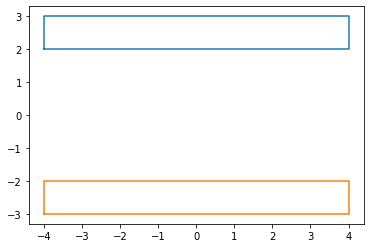

In [13]:
import matplotlib.pyplot as plt
upperbound = Polygon([(-4,2),(-4,3),(4,3),(4,2)])
Lowerbound = Polygon([(-4,-3),(-4,-2),(4,-2),(4,-3)])

x1,y1 = upperbound.exterior.xy
x2,y2 = Lowerbound.exterior.xy
plt.plot(x1,y1,x2,y2)